In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import torch
from torchvision.io import read_image
from torchvision import models, transforms, datasets
from torchinfo import summary
from torchviz import make_dot
from torch import nn, optim
import torchvision.transforms.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
dir(models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [4]:
weights = models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterRCNN = models.detection.fasterrcnn_resnet50_fpn(weights=weights)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 45.1MB/s] 


In [5]:
print(fasterRCNN)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
fasterRCNN = fasterRCNN.to(device)

In [7]:
fasterRCNN.eval()

x = [torch.rand(3, 300, 400).to(device),
     torch.rand(3, 500, 400).to(device)]

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

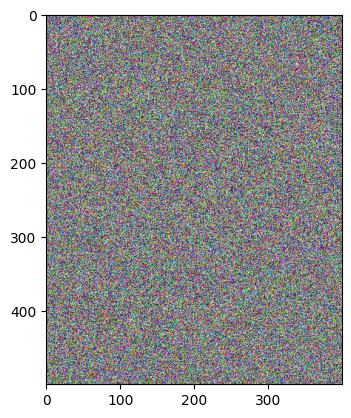

In [8]:
predictions = fasterRCNN(x)
display(predictions)

plt.imshow(x[1].cpu().permute(1, 2, 0))
plt.show()

In [9]:
class FasterRCNNWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        x = [img for img in x]
        output = self.model(x)
        
        return output
    
wrapped_model = FasterRCNNWrapper(fasterRCNN)
summary(wrapped_model, input_size=(2, 3, 226, 226))

Layer (type:depth-idx)                                       Output Shape              Param #
FasterRCNNWrapper                                            [0, 4]                    --
├─FasterRCNN: 1-1                                            [0, 4]                    --
│    └─GeneralizedRCNNTransform: 2-1                         [2, 3, 800, 800]          --
│    └─BackboneWithFPN: 2-2                                  [2, 256, 13, 13]          --
│    │    └─IntermediateLayerGetter: 3-1                     [2, 2048, 25, 25]         23,454,912
│    │    └─FeaturePyramidNetwork: 3-2                       [2, 256, 13, 13]          3,344,384
│    └─RegionProposalNetwork: 2-3                            [1000, 4]                 --
│    │    └─RPNHead: 3-3                                     [2, 3, 200, 200]          593,935
│    │    └─AnchorGenerator: 3-4                             [159882, 4]               --
│    └─RoIHeads: 2-4                                         [0, 4]        

In [10]:
coco_labels_list = weights.meta['categories']
print('COCO v1 dataset =', len(coco_labels_list))
display(coco_labels_list)

COCO v1 dataset = 91


['__background__',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'N/A',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'N/A',
 'backpack',
 'umbrella',
 'N/A',
 'N/A',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'N/A',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'N/A',
 'dining table',
 'N/A',
 'N/A',
 'toilet',
 'N/A',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'N/A',
 'book',
 'clock',
 'vase',
 'scissors',
 'ted

In [11]:
data_dir = './figure'

img_path = os.path.join(data_dir, 'dog.jpg')
img = read_image(img_path).to(device)

print(type(img))
print(img.shape)

<class 'torch.Tensor'>
torch.Size([3, 576, 768])


In [12]:
fasterRCNN = fasterRCNN.to(device)
preprocess = weights.transforms()
fasterRCNN

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
batch_img = preprocess(img)
batch_img.shape

torch.Size([3, 576, 768])

In [14]:
batch_img = batch_img.unsqueeze(0)
batch_img.shape

torch.Size([1, 3, 576, 768])

In [15]:
import time
fasterRCNN.eval()

start = time.time()
pred = fasterRCNN(batch_img)
stop = time.time()
print((stop-start)*1000)
pred

418.37120056152344


[{'boxes': tensor([[130.3128, 225.0554, 318.9828, 534.1508],
          [164.0084, 105.0131, 570.2531, 448.6728],
          [127.9848, 139.3225, 277.4211, 382.8216],
          [471.6425,  79.2251, 680.5767, 169.9889],
          [129.2798, 231.7075, 218.7069, 381.3174],
          [467.3610,  83.1271, 678.8610, 167.9795],
          [711.5847,  28.9596, 760.4271, 244.4193],
          [132.6403, 122.7344, 409.9254, 419.9329],
          [676.1611,  98.2453, 718.5075, 155.3477],
          [126.9417, 132.5706, 437.1504, 404.1093],
          [ 58.3277,  85.2246, 103.4922, 127.2871],
          [599.1246, 105.8132, 619.8698, 122.4651],
          [ 58.4251,  79.5118, 106.2428, 127.5731],
          [ 55.8647,  86.5849,  84.3212, 135.5832],
          [134.1762, 215.2632, 322.5450, 536.3416],
          [600.7084, 107.7193, 613.7567, 120.5402],
          [718.4606,  28.5328, 766.1630, 269.9453],
          [124.7294, 137.8185, 591.1368, 512.2672],
          [677.8741,  32.0603, 744.8705, 163.6991],
   

In [21]:
pred_dict = pred[0]
print(pred_dict.keys())
print(pred_dict['labels'])
print(pred_dict['scores'])

dict_keys(['boxes', 'labels', 'scores'])
tensor([18,  2,  2,  3,  2,  8, 64,  2, 64, 15, 64,  1,  4, 64, 17,  1, 72, 15,
        64,  4, 15, 62,  1, 62], device='cuda:0')
tensor([0.9961, 0.9843, 0.8170, 0.7619, 0.6026, 0.5444, 0.3443, 0.3338, 0.2976,
        0.2786, 0.2554, 0.2541, 0.2079, 0.2048, 0.1954, 0.1516, 0.1402, 0.1046,
        0.0957, 0.0941, 0.0801, 0.0672, 0.0617, 0.0501], device='cuda:0',
       grad_fn=<IndexBackward0>)


In [23]:
threshold = 0.7
indices = pred_dict['scores'] >= threshold
print(indices)

pred_boxes = pred_dict['boxes'][indices]
pred_labels = pred_dict['labels'][indices]
pred_scores = pred_dict['scores'][indices]

print(pred_boxes)
print(pred_labels)
print(pred_scores)

tensor([ True,  True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False], device='cuda:0')
tensor([[130.3128, 225.0554, 318.9828, 534.1508],
        [164.0084, 105.0131, 570.2531, 448.6728],
        [127.9848, 139.3225, 277.4211, 382.8216],
        [471.6425,  79.2251, 680.5767, 169.9889]], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor([18,  2,  2,  3], device='cuda:0')
tensor([0.9961, 0.9843, 0.8170, 0.7619], device='cuda:0',
       grad_fn=<IndexBackward0>)


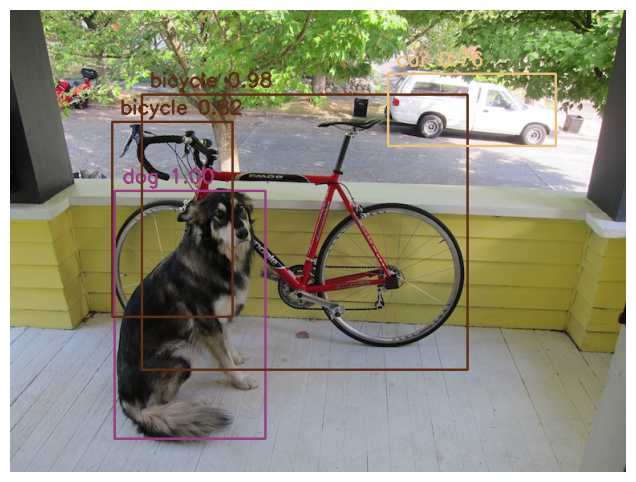

In [39]:
import random

image = img.permute(1, 2, 0).cpu().numpy()
color_array = [[random.randint(0, 255) for _ in range(3)] for _ in range(91)]

for i in range(len(pred_boxes)):
    x_min = int(pred_boxes[i][0])
    y_min = int(pred_boxes[i][1])
    x_max = int(pred_boxes[i][2])
    y_max = int(pred_boxes[i][3])

    color = color_array[pred_labels[i]]

    cv2.rectangle(image, pt1=(x_min, y_min), pt2=(x_max, y_max), color=color,
                  thickness=2)
    cv2.putText(image, text=coco_labels_list[pred_labels[i]] + ' {:.2f}'.format(pred_scores[i].item()),
                org=(x_min+10, y_min-10),
                fontFace=0,
                fontScale=0.8,
                color=color, thickness=2)
    
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.grid(None)
plt.axis('off')
plt.show()

In [40]:
def show(imgs: list):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols=len(imgs), figsize=(12, 6), squeeze=False)

    for i, img in enumerate(imgs):
        img = F.to_pil_image(img)
        axs[0, i].imshow(img)
        axs[0, i].axis('off')

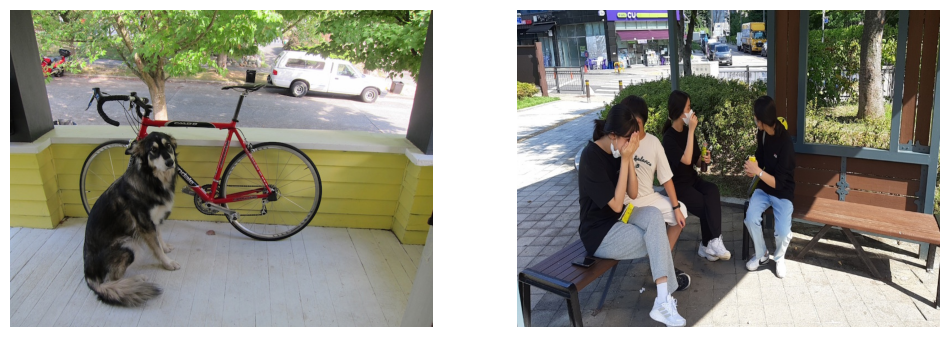

In [41]:
from torchvision.utils import make_grid
from torchvision.io import read_image

data_dir = './figure'

img1 = read_image(os.path.join(data_dir, 'dog.jpg'))
img2 = read_image(os.path.join(data_dir, 'peoples.jpg'))

img_list = [img1, img2]
show(img_list)

c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\torchvision\utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


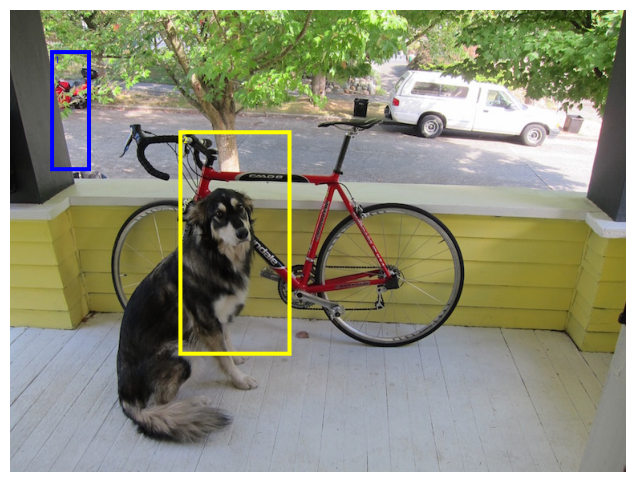

In [43]:
from torchvision.utils import draw_bounding_boxes
from PIL import Image

pred_boxes = torch.tensor([[50, 50, 100, 200],
                           [210, 150, 350, 430]], dtype=torch.float)

labels = ['1', '2']
colors = ['blue', 'yellow']

retult = draw_bounding_boxes(img1, pred_boxes, labels, colors, width=5,
                             font_size=20)
show(retult)

In [44]:
weights = models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterRCNN = models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(device)

In [45]:
transforms = weights.transforms()
images = [transforms(d).to(device) for d in img_list]

In [57]:
fasterRCNN.eval()
outputs = fasterRCNN(images)

In [71]:
print(outputs[0]['boxes'].shape)
print(outputs[0]['labels'].shape)
print(outputs[0]['scores'].shape)
print(len(outputs))

torch.Size([24, 4])
torch.Size([24])
torch.Size([24])
2


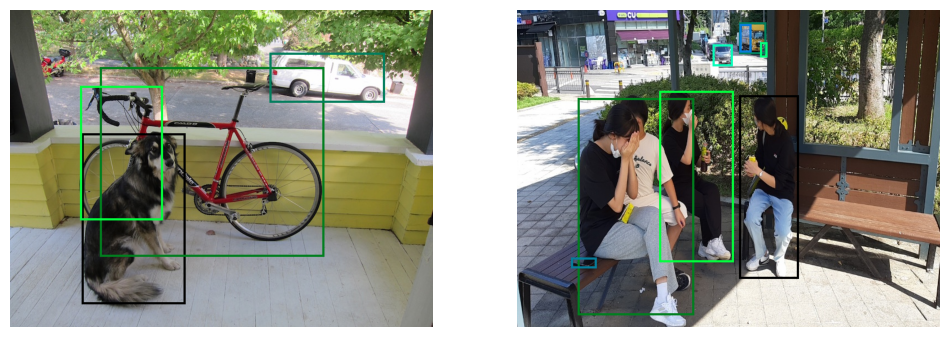

In [72]:
score_threshold = .7
dogs_with_boxes = [
    draw_bounding_boxes(img, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img, output in zip(img_list, outputs)]
show(dogs_with_boxes)

In [74]:
dir(models.segmentation)

['DeepLabV3',
 'DeepLabV3_MobileNet_V3_Large_Weights',
 'DeepLabV3_ResNet101_Weights',
 'DeepLabV3_ResNet50_Weights',
 'FCN',
 'FCN_ResNet101_Weights',
 'FCN_ResNet50_Weights',
 'LRASPP',
 'LRASPP_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'deeplabv3',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'fcn',
 'fcn_resnet101',
 'fcn_resnet50',
 'lraspp',
 'lraspp_mobilenet_v3_large']

In [75]:
weights = models.segmentation.FCN_ResNet50_Weights.DEFAULT
model = models.segmentation.fcn_resnet50(weights=weights, progress=True).to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:03<00:00, 47.1MB/s] 


In [76]:
transforms = weights.transforms(resize_size=None)
print(transforms)

SemanticSegmentation(
    resize_size=None
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [78]:
batch = torch.stack([transforms(d) for d in img_list]).to(device)
batch.shape

torch.Size([2, 3, 576, 768])

In [85]:
model.eval()

print(model(batch))

OrderedDict([('out', tensor([[[[ 8.4724e+00,  8.4724e+00,  8.4724e+00,  ...,  8.2255e+00,
            8.2255e+00,  8.2255e+00],
          [ 8.4724e+00,  8.4724e+00,  8.4724e+00,  ...,  8.2255e+00,
            8.2255e+00,  8.2255e+00],
          [ 8.4724e+00,  8.4724e+00,  8.4724e+00,  ...,  8.2255e+00,
            8.2255e+00,  8.2255e+00],
          ...,
          [ 9.5278e+00,  9.5278e+00,  9.5278e+00,  ...,  6.7375e+00,
            6.7375e+00,  6.7375e+00],
          [ 9.5278e+00,  9.5278e+00,  9.5278e+00,  ...,  6.7375e+00,
            6.7375e+00,  6.7375e+00],
          [ 9.5278e+00,  9.5278e+00,  9.5278e+00,  ...,  6.7375e+00,
            6.7375e+00,  6.7375e+00]],

         [[ 7.8550e-01,  7.8550e-01,  7.8550e-01,  ..., -7.3024e-01,
           -7.3024e-01, -7.3024e-01],
          [ 7.8550e-01,  7.8550e-01,  7.8550e-01,  ..., -7.3024e-01,
           -7.3024e-01, -7.3024e-01],
          [ 7.8550e-01,  7.8550e-01,  7.8550e-01,  ..., -7.3024e-01,
           -7.3024e-01, -7.3024e-01],

In [87]:
output = model(batch)['out']
print(output.shape)

torch.Size([2, 21, 576, 768])


In [83]:
print(weights.meta.keys())
print(weights.meta['categories'])
print(len(weights.meta['categories']))

dict_keys(['categories', 'min_size', '_docs', 'num_params', 'recipe', '_metrics', '_ops', '_file_size'])
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
21


In [84]:
sem_class_to_idx = {cls: idx for idx, cls in enumerate(weights.meta['categories'])}
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

In [90]:
normalized_masks = torch.softmax(output, dim=1)
print(normalized_masks)
print(normalized_masks.shape)

tensor([[[[9.9259e-01, 9.9259e-01, 9.9259e-01,  ..., 9.9091e-01,
           9.9091e-01, 9.9091e-01],
          [9.9259e-01, 9.9259e-01, 9.9259e-01,  ..., 9.9091e-01,
           9.9091e-01, 9.9091e-01],
          [9.9259e-01, 9.9259e-01, 9.9259e-01,  ..., 9.9091e-01,
           9.9091e-01, 9.9091e-01],
          ...,
          [9.9619e-01, 9.9619e-01, 9.9619e-01,  ..., 9.5268e-01,
           9.5268e-01, 9.5268e-01],
          [9.9619e-01, 9.9619e-01, 9.9619e-01,  ..., 9.5268e-01,
           9.5268e-01, 9.5268e-01],
          [9.9619e-01, 9.9619e-01, 9.9619e-01,  ..., 9.5268e-01,
           9.5268e-01, 9.5268e-01]],

         [[4.5542e-04, 4.5542e-04, 4.5542e-04,  ..., 1.2782e-04,
           1.2782e-04, 1.2782e-04],
          [4.5542e-04, 4.5542e-04, 4.5542e-04,  ..., 1.2782e-04,
           1.2782e-04, 1.2782e-04],
          [4.5542e-04, 4.5542e-04, 4.5542e-04,  ..., 1.2782e-04,
           1.2782e-04, 1.2782e-04],
          ...,
          [2.2416e-05, 2.2416e-05, 2.2416e-05,  ..., 4.4149

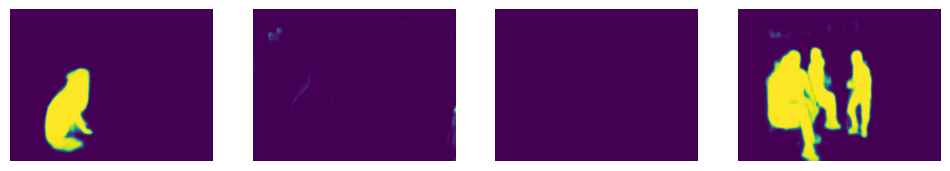

In [91]:
dog_and_person_mask = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(img_list)) for cls in ('dog', 'person')
]

show(dog_and_person_mask)

In [93]:
for cls in ('dog', 'person'):
    print(sem_class_to_idx[cls])

12
15


In [94]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(dim = class_dim) == sem_class_to_idx['person']) | \
                    (normalized_masks.argmax(dim = class_dim) == sem_class_to_idx['dog'])  

torch.Size([2, 576, 768])
torch.bool


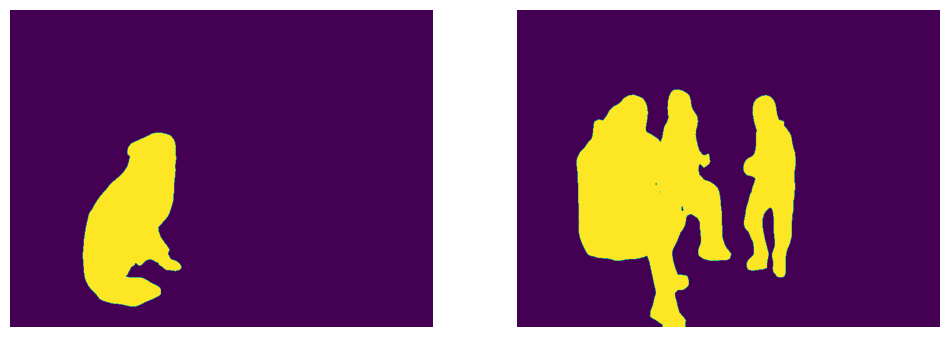

In [99]:
print(boolean_dog_masks.shape)
print(boolean_dog_masks.dtype)
show([m.float() for m in boolean_dog_masks])

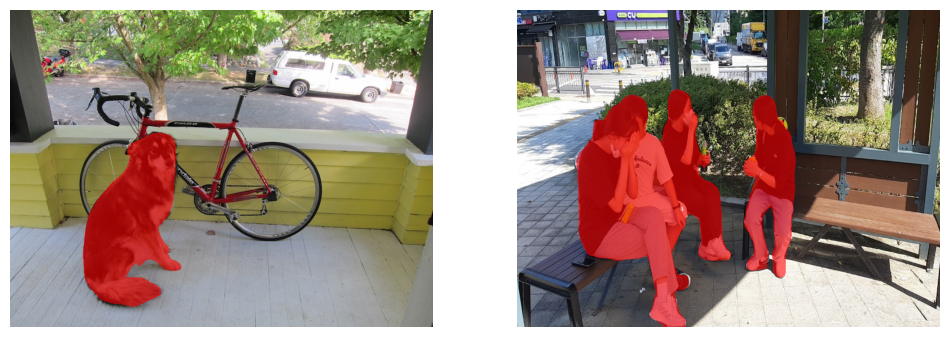

In [102]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, colors='red', alpha=0.6)
    for img, mask in zip(img_list, boolean_dog_masks)
]

show(dogs_with_masks)